In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH_NUMS_SUITS = './Datasets/sn/poker_nums_suits/PokerCards_dataset/'
DATA_PATH_CARDS = './Datasets/Cards/'

Directorio actual: c:\Users\moise\Documents\0001_MADI\DeepLearning\Notebooks\CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten
)
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Global variables
SIZE = 224
NUM_CLASSES = 13  # Ace, 2-13 (Jack=11, Queen=12, King=13)
SUIT_CLASSES = 4  # Clubs, Diamonds, Hearts, Spades
EPOCHS = 50
PATIENCE_ES = 15
BATCH_SIZE = 64

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')


TensorFlow version: 2.15.0
GPU disponible: []


## Preparar datos para NÚMEROS (Ace, 2-13)

In [3]:
# Mapeo de carpetas a índices para NÚMEROS
NUM_FOLDER_MAP = {
    'Ace': 0, '2': 1, '3': 2, '4': 3, '5': 4,
    '6': 5, '7': 6, '8': 7, '9': 8, '10': 9,
    '11': 10, '12': 11, '13': 12  # 11=Jack, 12=Queen, 13=King
}

NUM_NAMES = ['Ace', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King']

# Verificar carpetas disponibles
num_folders = [f.name for f in Path(DATA_PATH_NUMS_SUITS).iterdir() if f.is_dir() and f.name in NUM_FOLDER_MAP]
print(f'Carpetas de números encontradas: {sorted(num_folders)}')

Carpetas de números encontradas: ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9', 'Ace']


In [5]:
# Data augmentation para números
train_gen_nums = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    validation_split=0.15  # 15% para validación
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

# Cargar SOLO carpetas de números (excluir Clubs, Diamonds, Hearts, Spades)
train_dataset_nums = train_gen_nums.flow_from_directory(
    DATA_PATH_NUMS_SUITS,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
    classes=list(NUM_FOLDER_MAP.keys())  # Solo números
)

valid_dataset_nums = train_gen_nums.flow_from_directory(
    DATA_PATH_NUMS_SUITS,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation',
    classes=list(NUM_FOLDER_MAP.keys())
)

print(f'\nClases (números): {train_dataset_nums.class_indices}')

Found 5878 images belonging to 13 classes.
Found 1031 images belonging to 13 classes.

Clases (números): {'Ace': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '10': 9, '11': 10, '12': 11, '13': 12}


## Preparar datos para PALOS (Clubs, Diamonds, Hearts, Spades)

In [6]:
# Mapeo de carpetas a índices para PALOS
SUIT_FOLDER_MAP = {
    'Clubs': 0, 'Diamonds': 1, 'Hearts': 2, 'Spades': 3
}

SUIT_NAMES = ['Clubs', 'Diamonds', 'Hearts', 'Spades']

# Verificar carpetas disponibles
suit_folders = [f.name for f in Path(DATA_PATH_NUMS_SUITS).iterdir() if f.is_dir() and f.name in SUIT_FOLDER_MAP]
print(f'Carpetas de palos encontradas: {sorted(suit_folders)}')

Carpetas de palos encontradas: ['Clubs', 'Diamonds', 'Hearts', 'Spades']


In [7]:
# Data augmentation para palos
train_gen_suits = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    validation_split=0.15
)

# Cargar SOLO carpetas de palos
train_dataset_suits = train_gen_suits.flow_from_directory(
    DATA_PATH_NUMS_SUITS,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
    classes=list(SUIT_FOLDER_MAP.keys())  # Solo palos
)

valid_dataset_suits = train_gen_suits.flow_from_directory(
    DATA_PATH_NUMS_SUITS,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation',
    classes=list(SUIT_FOLDER_MAP.keys())
)

print(f'\nClases (palos): {train_dataset_suits.class_indices}')

Found 1653 images belonging to 4 classes.
Found 289 images belonging to 4 classes.

Clases (palos): {'Clubs': 0, 'Diamonds': 1, 'Hearts': 2, 'Spades': 3}


## Construir Modelo para NÚMEROS

In [8]:
# Base: MobileNetV2 pre-entrenada
base_nums = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(SIZE, SIZE, 3)
)

# Congelar primeras capas
for layer in base_nums.layers[:100]:
    layer.trainable = False

# Arquitectura para números
inputs = Input(shape=(SIZE, SIZE, 3))
x = base_nums(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='num_output')(x)

model_nums = Model(inputs=inputs, outputs=outputs, name='NumberClassifier')
model_nums.summary()



9406464/9406464 [==============================] - 4s 0us/step
Model: "NumberClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                   

In [8]:
# Compilar modelo de números
model_nums.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_nums = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, 'NumsClassifier.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_nums = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE_ES,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_nums = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [9]:
# Entrenar modelo de números
print('\n=== Entrenando Clasificador de NÚMEROS ===')
history_nums = model_nums.fit(
    train_dataset_nums,
    validation_data=valid_dataset_nums,
    epochs=EPOCHS,
    callbacks=[checkpoint_nums, early_stop_nums, reduce_lr_nums],
    verbose=1
)


=== Entrenando Clasificador de NÚMEROS ===
Epoch 1/50
Epoch 1/50


I0000 00:00:1764810287.354715   11308 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8852
Epoch 1: val_accuracy improved from -inf to 0.30068, saving model to Models/NumsClassifier.h5

Epoch 1: val_accuracy improved from -inf to 0.30068, saving model to Models/NumsClassifier.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 87s 823ms/step - loss: 0.4200 - accuracy: 0.8852 - val_loss: 11.4291 - val_accuracy: 0.3007 - lr: 0.0010
Epoch 2/50
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9794
Epoch 2: val_accuracy did not improve from 0.30068
92/92 [==============================] - 67s 727ms/step - loss: 0.1318 - accuracy: 0.9794 - val_loss: 12.1913 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50

Epoch 2: val_accuracy did not improve from 0.30068
92/92 [==============================] - 67s 727ms/step - loss: 0.1318 - accuracy: 0.9794 - val_loss: 12.1913 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9879
Epoch 3: val_accuracy did not improve from 0.30068
92/92 [==============================] - 68s 732ms/step - loss: 0.1108 - accuracy: 0.9879 - val_loss: 21.7142 - val_accuracy: 0.1222 - lr: 0.0010

Epoch 3: val_accuracy did not improve from 0.30068


## Construir Modelo para PALOS

In [9]:
# Base: MobileNetV2 pre-entrenada (nueva instancia)
base_suits = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(SIZE, SIZE, 3)
)

# Congelar primeras capas
for layer in base_suits.layers[:100]:
    layer.trainable = False

# Arquitectura para palos
inputs = Input(shape=(SIZE, SIZE, 3))
x = base_suits(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = Dense(SUIT_CLASSES, activation='softmax', name='suit_output')(x)

model_suits = Model(inputs=inputs, outputs=outputs, name='SuitClassifier')
model_suits.summary()

Model: "SuitClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)             

In [13]:
# Compilar modelo de palos
model_suits.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_suits = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, 'SuitsClassifier.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_suits = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE_ES,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_suits = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [14]:
# Entrenar modelo de palos
print('\n=== Entrenando Clasificador de PALOS ===')
history_suits = model_suits.fit(
    train_dataset_suits,
    validation_data=valid_dataset_suits,
    epochs=EPOCHS,
    callbacks=[checkpoint_suits, early_stop_suits, reduce_lr_suits],
    verbose=1
)


=== Entrenando Clasificador de PALOS ===
Epoch 1/50
Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8711
Epoch 1: val_accuracy improved from -inf to 0.31142, saving model to Models/SuitsClassifier.h5

Epoch 1: val_accuracy improved from -inf to 0.31142, saving model to Models/SuitsClassifier.h5
26/26 [==============================] - 32s 943ms/step - loss: 0.3883 - accuracy: 0.8711 - val_loss: 7.6380 - val_accuracy: 0.3114 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - 32s 943ms/step - loss: 0.3883 - accuracy: 0.8711 - val_loss: 7.6380 - val_accuracy: 0.3114 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.9794
Epoch 2: val_accuracy did not improve from 0.31142
26/26 [==============================] - 17s 662ms/step - loss: 0.1004 - accuracy: 0.9794 - val_loss: 13.8730 - val_accuracy: 0.2699 - lr: 0.0010

Epoch 2: val_accuracy did not improve from 0.31142
26/26 [===========

: 

: 

: 

## Visualizar resultados de entrenamiento

In [10]:
def plot_history(h, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(h.history['loss'], label='Train Loss')
    axes[0].plot(h.history['val_loss'], label='Val Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(h.history['accuracy'], label='Train Accuracy')
    axes[1].plot(h.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_history(history_nums, 'Number Classifier')
plot_history(history_suits, 'Suit Classifier')

NameError: name 'history_nums' is not defined

## Evaluar en dataset Cards/test (cartas completas)

In [11]:
# Cargar mejores modelos
model_nums_best = tf.keras.models.load_model(os.path.join(path_models, 'NumsClassifier.h5'))
model_suits_best = tf.keras.models.load_model(os.path.join(path_models, 'SuitsClassifier.h5'))

print('Modelos cargados correctamente')

Modelos cargados correctamente


In [12]:
# Mapeo de nombres de carpetas del dataset Cards a índices
# Formato: "ace of clubs", "two of hearts", etc.
CARDS_NUM_MAP = {
    'ace': 0, 'two': 1, 'three': 2, 'four': 3, 'five': 4,
    'six': 5, 'seven': 6, 'eight': 7, 'nine': 8, 'ten': 9,
    'jack': 10, 'queen': 11, 'king': 12
}

CARDS_SUIT_MAP = {
    'clubs': 0, 'diamonds': 1, 'hearts': 2, 'spades': 3
}

def parse_card_name(folder_name):
    """Extrae número y palo del nombre de carpeta del dataset Cards"""
    if 'joker' in folder_name.lower():
        return None, None
    
    parts = folder_name.lower().split(' of ')
    if len(parts) != 2:
        return None, None
    
    num_name, suit_name = parts
    num_idx = CARDS_NUM_MAP.get(num_name)
    suit_idx = CARDS_SUIT_MAP.get(suit_name)
    
    return num_idx, suit_idx

# Test
print(parse_card_name('ace of clubs'))  # (0, 0)
print(parse_card_name('king of hearts'))  # (12, 2)

(0, 0)
(12, 2)


In [13]:
# Cargar imágenes del dataset Cards/test
test_path = DATA_PATH_CARDS + 'test'

test_images = []
true_nums = []
true_suits = []
image_paths = []

for folder in Path(test_path).iterdir():
    if folder.is_dir():
        num_idx, suit_idx = parse_card_name(folder.name)
        if num_idx is not None and suit_idx is not None:
            for img_path in folder.glob('*.jpg'):
                # Cargar y preprocesar imagen
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(SIZE, SIZE))
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                
                test_images.append(img_array)
                true_nums.append(num_idx)
                true_suits.append(suit_idx)
                image_paths.append(str(img_path))

test_images = np.array(test_images)
true_nums = np.array(true_nums)
true_suits = np.array(true_suits)

print(f'\nCargadas {len(test_images)} imágenes de test')
print(f'Shape: {test_images.shape}')


Cargadas 260 imágenes de test
Shape: (260, 224, 224, 3)


In [14]:
# Predecir números y palos
print('\nPrediciendo números...')
pred_nums_probs = model_nums_best.predict(test_images, verbose=1)
pred_nums = pred_nums_probs.argmax(axis=1)

print('\nPrediciendo palos...')
pred_suits_probs = model_suits_best.predict(test_images, verbose=1)
pred_suits = pred_suits_probs.argmax(axis=1)

# Calcular accuracy individual
num_accuracy = (pred_nums == true_nums).mean()
suit_accuracy = (pred_suits == true_suits).mean()

# Accuracy combinada (ambos correctos)
combined_correct = (pred_nums == true_nums) & (pred_suits == true_suits)
combined_accuracy = combined_correct.mean()

print(f'\n=== Resultados en Cards/test ===')
print(f'Accuracy NÚMEROS: {num_accuracy:.4f} ({num_accuracy*100:.2f}%)')
print(f'Accuracy PALOS:   {suit_accuracy:.4f} ({suit_accuracy*100:.2f}%)')
print(f'Accuracy COMBINADA (carta completa): {combined_accuracy:.4f} ({combined_accuracy*100:.2f}%)')


Prediciendo números...
9/9 [==============================] - 2s 150ms/step

Prediciendo palos...
9/9 [==============================] - 2s 144ms/step

=== Resultados en Cards/test ===
Accuracy NÚMEROS: 0.1077 (10.77%)
Accuracy PALOS:   0.2769 (27.69%)
Accuracy COMBINADA (carta completa): 0.0269 (2.69%)


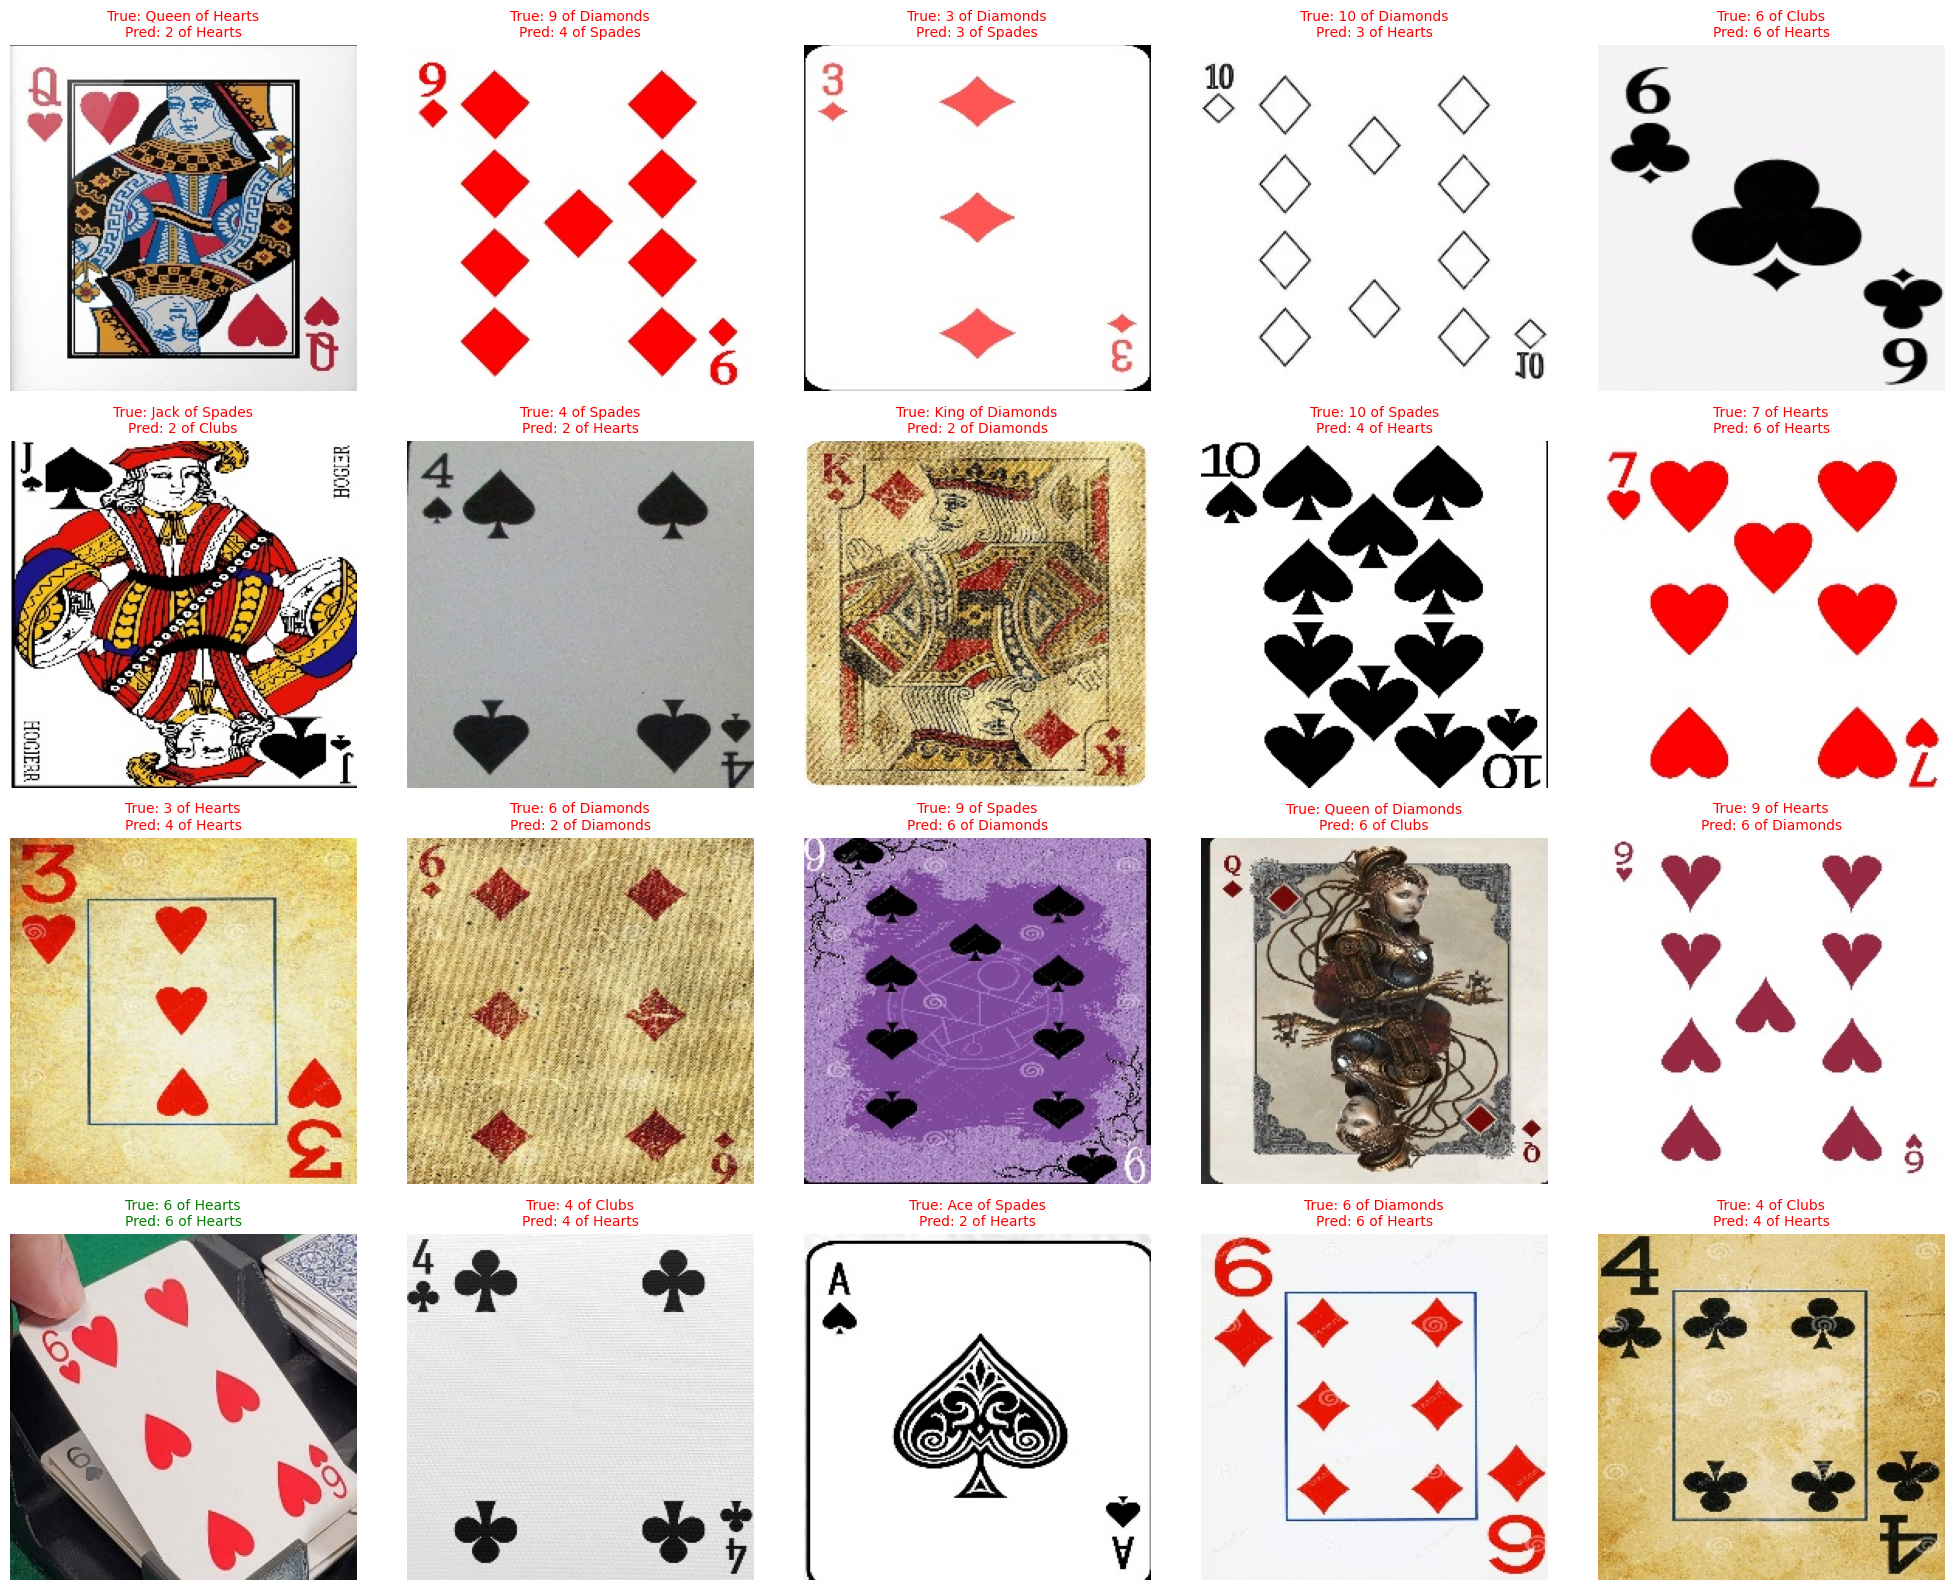

In [15]:
# Visualizar algunas predicciones
num_samples = 20
indices = np.random.choice(len(test_images), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(test_images[idx])
    
    true_num_name = NUM_NAMES[true_nums[idx]]
    true_suit_name = SUIT_NAMES[true_suits[idx]]
    pred_num_name = NUM_NAMES[pred_nums[idx]]
    pred_suit_name = SUIT_NAMES[pred_suits[idx]]
    
    is_correct = combined_correct[idx]
    color = 'green' if is_correct else 'red'
    
    axes[i].set_title(
        f'True: {true_num_name} of {true_suit_name}\n'
        f'Pred: {pred_num_name} of {pred_suit_name}',
        color=color,
        fontsize=10
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Análisis de errores

In [ ]:
# Errores solo en números
num_errors = (pred_nums != true_nums) & (pred_suits == true_suits)
print(f'Errores SOLO en número: {num_errors.sum()} ({num_errors.mean()*100:.2f}%)')

# Errores solo en palos
suit_errors = (pred_nums == true_nums) & (pred_suits != true_suits)
print(f'Errores SOLO en palo:   {suit_errors.sum()} ({suit_errors.mean()*100:.2f}%)')

# Errores en ambos
both_errors = (pred_nums != true_nums) & (pred_suits != true_suits)
print(f'Errores en AMBOS:       {both_errors.sum()} ({both_errors.mean()*100:.2f}%)')

# Total de errores
total_errors = (~combined_correct).sum()
print(f'\nTotal de errores: {total_errors} / {len(test_images)}')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reporte de clasificación para números
print('\n=== Classification Report - NÚMEROS ===')
print(classification_report(true_nums, pred_nums, target_names=NUM_NAMES))

In [ ]:
# Reporte de clasificación para palos
print('\n=== Classification Report - PALOS ===')
print(classification_report(true_suits, pred_suits, target_names=SUIT_NAMES))

In [ ]:
# Matriz de confusión para números
cm_nums = confusion_matrix(true_nums, pred_nums)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm_nums, annot=True, fmt='d', cmap='Blues', 
            xticklabels=NUM_NAMES, yticklabels=NUM_NAMES, ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix - Números')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Matriz de confusión para palos
cm_suits = confusion_matrix(true_suits, pred_suits)

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(cm_suits, annot=True, fmt='d', cmap='Greens', 
            xticklabels=SUIT_NAMES, yticklabels=SUIT_NAMES, ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix - Palos')
plt.tight_layout()
plt.show()

## Guardar resultados

In [ ]:
# Guardar resultados en CSV
results_df = pd.DataFrame({
    'Model': ['NumsClassifier', 'SuitsClassifier', 'Combined (Ensemble)'],
    'Accuracy': [num_accuracy, suit_accuracy, combined_accuracy],
    'Error_Rate': [1-num_accuracy, 1-suit_accuracy, 1-combined_accuracy]
})

results_df.to_csv(os.path.join(path_results, 'nums_suits_results.csv'), index=False)
print('\nResultados guardados en Results/nums_suits_results.csv')
print(results_df)

In [ ]:
# Comparativa visual
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Números', 'Palos', 'Combinado\n(Ensemble)']
accuracies = [num_accuracy, suit_accuracy, combined_accuracy]
colors = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax.bar_label(bars, fmt='%.4f', padding=5)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparación de Accuracy - Clasificadores Separados vs Ensemble', fontsize=14)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(path_results, 'nums_suits_comparison.png'), dpi=150)
plt.show()

print('\nGráfico guardado en Results/nums_suits_comparison.png')